# Transitioning to autonomous driving: <br>Mixed vehicle autonomy levels on freeways
### Notebook to analyse simulation warm-up time.

Jesse Poland<br>
TU Delft<br>
Date: 02-10-2024<br>

### 0. Python packages and loading data files

First, Python packages are imported to provide specific functionalities within the notebook. Then, the file paths are set to retrieve stored simulation data for all experiment runs and seeds. The simulation data is loaded into Pandas DataFrames, making the data ready for analysis.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# simulation output folder
experiment_name = 'full_level_runs_4'

# load Java simulation data
experiment_folder = fr'C:\Users\jesse\Documents\EPA_TUDelft\MasterThesis\thesis_experiments\SIMLAB-BOTLEK\{experiment_name}'

# available files
input_values = 'inputValues.csv'
intermediate_output = 'intermediateOutputData.csv'
single_output = 'singleOutputData.csv'
sequence_output = 'sequenceOutputData.csv'
lane_change_output = 'laneChangeOutputData.csv'

In [3]:
# function to get a list of all file/folder names within a folder
def get_file_names(path):
    return os.listdir(path)

# load available seed folders
seed_folders = get_file_names(experiment_folder)

In [4]:
# load all available data for all seeds and runs
# combine the available data files with input values

# function to retrieve single data
def load_single_data(folder1, folder2, file, input_file):
    # create and save empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in folder2:
        # get all runs within this seed
        run_folders = get_file_names(os.path.join(folder1, seed_name))
        
        # get single data for all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            folder = os.path.join(folder1, seed_name, run_folder)
            data_path = os.path.join(folder, file)
            input_path = os.path.join(folder, input_file)
    
            # process run data
            df_run = pd.read_csv(data_path)
            df_run['run'] = run_number
            df_run.set_index('run', inplace=True)
    
            # add input data
            df_input = pd.read_csv(input_path)
            df_input['run'] = run_number
            df_input.set_index('run', inplace=True)
            df_run = pd.concat([df_run, df_input], axis=1)
    
            # add this data to the mean values DataFrame
            df = pd.concat([df, df_run])
    
    # sort DataFrame
    df.sort_index(inplace=True)
    df.reset_index(drop=False, inplace=True)

    # return DataFrame
    return df


# function to retrieve intermediate data
def load_intermediate_data(folder1, folder2, file, input_file):
    # create and save empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in folder2:
        # get all runs within this seed
        run_folders = get_file_names(os.path.join(folder1, seed_name))
        
        # get single data for all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            folder = os.path.join(folder1, seed_name, run_folder)
            data_path = os.path.join(folder, file)
            input_path = os.path.join(folder, input_file)
    
            # process run data
            df_run = pd.read_csv(data_path)
            df_run['run'] = run_number
    
            # process input data
            df_input = pd.read_csv(input_path)
    
            # broadcast input data to all rows in df_run
            for col in df_input.columns:
                df_run[col] = df_input[col].iloc[0]
    
            # add this data to the main DataFrame
            df = pd.concat([df, df_run])
    
    # sort DataFrame
    df.sort_index(inplace=True)
    df.index.name = 'time'
    df.reset_index(drop=False, inplace=True)
    df['time'] = df['time'] / 2

    # return DataFrame
    return df


# function to retrieve sequence data
def load_sequence_data(folder1, folder2, file, input_file, save_name):
    # create empty DataFrame
    df = pd.DataFrame()
    
    # loop through all seed folders from this experiment
    for seed_name in folder2:
        # load current version of DataFrame
        
        print(f'\n{seed_name}')
        
        # get all runs within this experiment
        run_folders = get_file_names(os.path.join(folder1, seed_name))
        
        # get acceleration data for all runs
        for run_folder in run_folders:
            run_number = int(run_folder.split('_')[1])
            folder = os.path.join(folder1, seed_name, run_folder)
            data_path = os.path.join(folder, file)
            input_path = os.path.join(folder, input_file)
    
            # process run data
            df_run = pd.read_csv(data_path)
            df_run['run'] = run_number
    
            # process input data
            df_input = pd.read_csv(input_path)
    
            # broadcast input data to all rows in df_run
            for col in df_input.columns:
                df_run[col] = df_input[col].iloc[0]
    
            # add this data to the main DataFrame
            df = pd.concat([df, df_run])
            print(f'Loaded data into DataFrame for: {run_folder}')

        # save data for each seed
        parquet_file_path = os.path.join(f'{save_name}_{seed_name}.parquet')
        df.to_parquet(parquet_file_path, engine='pyarrow')

    # return sequence DataFrame
    return df
    

In [5]:
# get single data
df_single = load_single_data(experiment_folder, seed_folders, single_output, input_values)

# get intermediate data
df_intermediate = load_intermediate_data(experiment_folder, seed_folders, intermediate_output, input_values)

# get sequence data
df_sequence = pd.read_parquet('warm_up_sequence_data_seed_0.parquet', engine='pyarrow')
# df_sequence = load_sequence_data(experiment_folder, seed_folders, sequence_output, input_values, 'warm_up_sequence_data')

### 1. Analyse progress of simulation variables

Selected variables are chosen and their progress is plotted. It is likely that the values of a variable will approach a stable value. This stabalization will indicate that the simulation has achieved a stable state.

In [6]:
# selected warm-up time
# warm_up_time = None
warm_up_time = 364

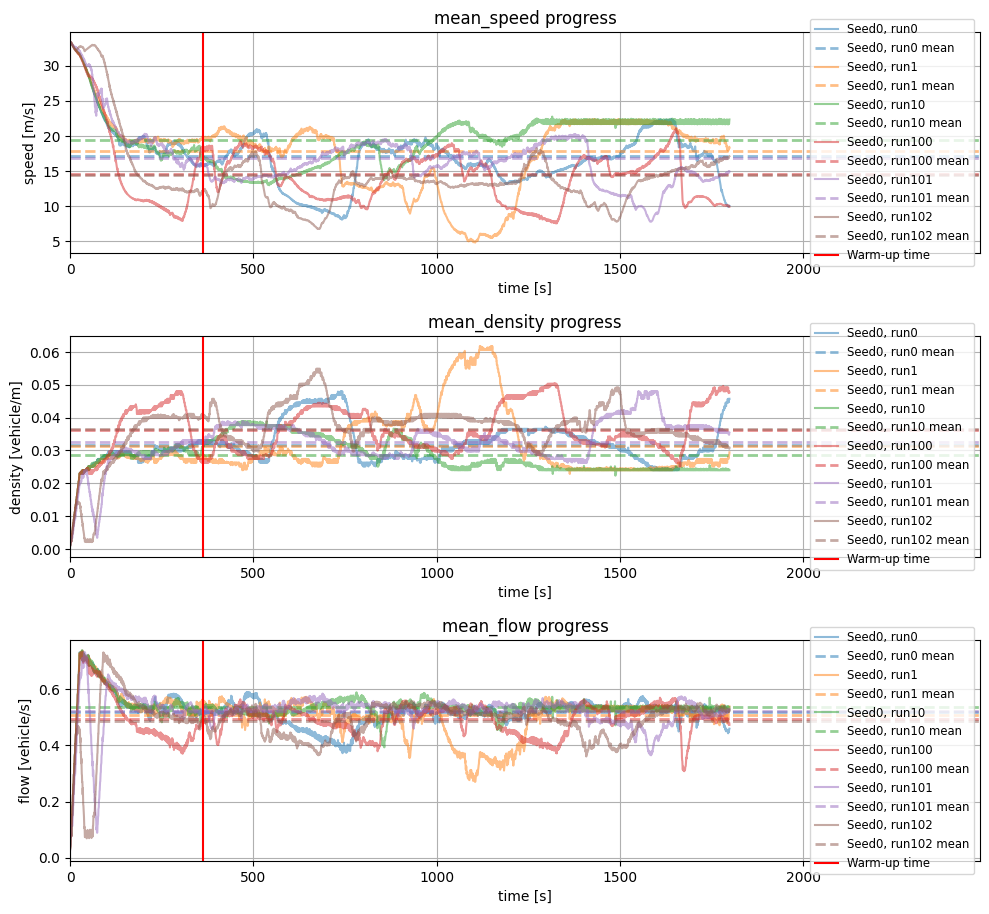

In [7]:
# get mean values
df_mean = df_single.copy()
        
# only include mean variables (and seed and run numbers)
variables_of_interest = ['time', 'seed', 'run', 'mean_speed', 'mean_flow', 'mean_density']
columns_to_include = [col for col in df_intermediate.columns if col in variables_of_interest]
df_filtered = df_intermediate[columns_to_include]

# create plots for all variables
n_columns = 1
n_rows = (len(df_filtered.columns) + 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, n_rows * 3))
axes = axes.flatten()

# Loop through each variable/column
for i, column in enumerate(df_filtered.columns.drop(['time', 'seed', 'run'])):
    # Group by 'run' and 'seed' combination
    run_seed_grouped = df_filtered.groupby(['run', 'seed'])

    # plot each run-seed combination
    for (run, seed), run_seed_group in run_seed_grouped:
        # plot line
        run_seed_group.reset_index()
        line, = axes[i].plot(run_seed_group['time'], run_seed_group[column], label=f'Seed{seed}, run{run}', alpha=0.5)
        line_color = line.get_color()
    
        # plot mean value
        if column in df_single.columns:
            final_mean_value = df_mean[(df_mean['seed'] == seed) & (df_mean['run'] == run)][column].values[0]
            axes[i].axhline(final_mean_value, color=line_color, linestyle='--', linewidth=2, label=f'Seed{seed}, run{run} mean', alpha=0.5)

    # plot selected warm-up time
    if warm_up_time is not None:
        axes[i].axvline(x=warm_up_time, color='red', label='Warm-up time')
        
    # set plot titles and labels
    units = '-'
    if 'speed' in column:
        units = 'm/s'
    elif 'flow' in column:
        units = 'vehicle/s'
    elif 'density' in column:
        units = 'vehicle/m'
        
    axes[i].set_title(f'{column} progress')
    axes[i].set_xlabel('time [s]')
    axes[i].set_ylabel(f'{column.split("_")[1]} [{units}]')
    axes[i].grid(True)
    axes[i].legend(loc='right', fontsize='small')

    # extend only the right (x_max) and top (y_max) by 10%
    x_min, x_max = axes[i].get_xlim()
    y_min, y_max = axes[i].get_ylim()
    axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show plots
plt.tight_layout()
plt.show()

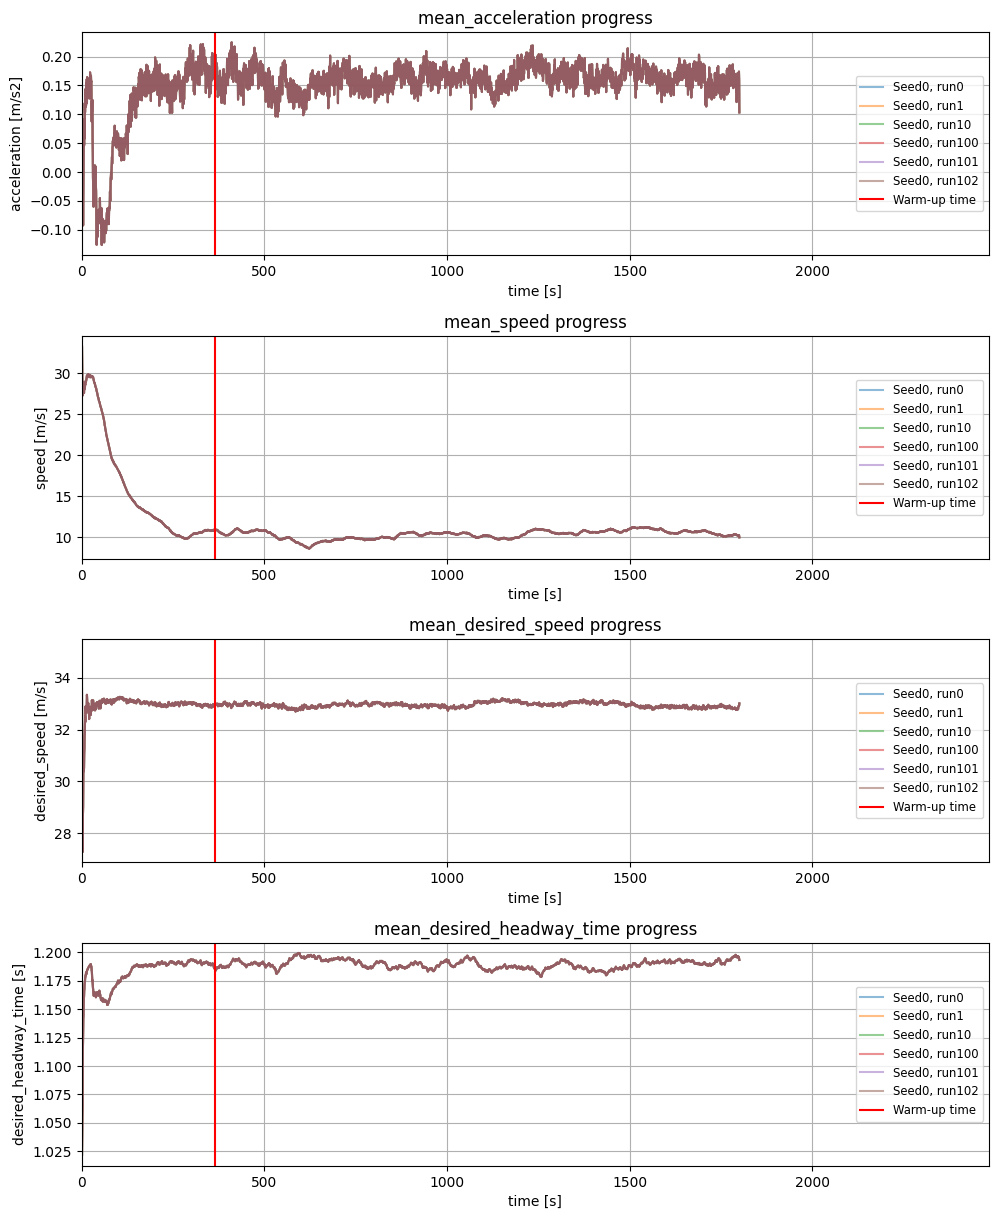

In [8]:
# only include mean variables (and seed and run numbers)
variables_of_interest = ['time', 'seed', 'run', 'acceleration', 'speed', 'desired_speed', 'desired_headway_time']
columns_to_include = [col for col in df_sequence.columns if col in variables_of_interest]
df_filtered = df_sequence[columns_to_include]

# create plots for all variables
n_columns = 1
n_rows = (len(df_filtered.columns) + 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(10, n_rows * 3))
axes = axes.flatten()

# loop through each variable/column
for i, column in enumerate(df_filtered.columns.drop(['time', 'seed', 'run'])):
    # group by run and seed combination
    run_seed_grouped = df_filtered.groupby(['run', 'seed'])

    # plot each run-seed combination
    for (run, seed), run_seed_group in run_seed_grouped:
        # calculate mean per time step
        df_mean_by_time = df_sequence.groupby('time').agg({column: 'mean',}).reset_index()
        
        # plot line
        line, = axes[i].plot(df_mean_by_time['time'], df_mean_by_time[column], label=f'Seed{seed}, run{run}', alpha=0.5)
        line_color = line.get_color()

    # plot selected warm-up time
    if warm_up_time is not None:
        axes[i].axvline(x=warm_up_time, color='red', label='Warm-up time')

    # set plot titles and labels
    units = '-'
    if 'speed' in column:
        units = 'm/s'
    elif 'acceleration' in column:
        units = 'm/s2'
    elif 'time' in column:
        units = 's'
        
    axes[i].set_title(f'mean_{column} progress')
    axes[i].set_xlabel('time [s]')
    axes[i].set_ylabel(f'{column} [{units}]')
    axes[i].grid(True)
    axes[i].legend(loc='right', fontsize='small')

    # extend only the right (x_max) and top (y_max) by 10%
    axes[i].set_xlim([0, x_max + 0.3 * (x_max - x_min)])
    
# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Show plots
plt.tight_layout()
plt.show()

In [9]:
# window size for sliding window significance test
window_size = int(df_sequence['time'].max() * 0.1)
print(f'Window size: {window_size}\n')

# only include mean variables (and seed and run numbers)
variables_of_interest = ['time', 'seed', 'run', 'acceleration', 'speed', 'desired_speed', 'desired_headway_time']
columns_to_include = [col for col in df_sequence.columns if col in variables_of_interest]
df_filtered = df_sequence[columns_to_include]

# dictionary to store warm-up times per variable
warm_up_time_dict = {}

# loop through each variable/column
for i, column in enumerate(df_filtered.columns.drop(['time', 'seed', 'run'])):
    # add column to dictionary with corresponding list
    warm_up_time_dict[column] = []
    
    # group by run and seed combination
    run_seed_grouped = df_filtered.groupby(['run', 'seed'])

    # loop through each run-seed combination
    for (run, seed), run_seed_group in run_seed_grouped:
        # calculate mean per time step
        df_mean_by_time = df_sequence.groupby('time').agg({column: 'mean',}).reset_index()
        df_mean_by_time.set_index('time', inplace=True)

        # determine warm-up time
        for t in range(window_size, len(df_mean_by_time)):
            # compare the distribution of the variable before and after time `t`
            pre_warmup = df_mean_by_time[column][t-window_size:t]
            post_warmup = df_mean_by_time[column][t:t+window_size]
    
            # ensure non-zero sizes for both slices
            if len(pre_warmup) > 0 and len(post_warmup) > 0:
                # perform Mann-Whitney U Test
                stat, p_value = mannwhitneyu(pre_warmup, post_warmup)
    
                # determine if the null hypothesis is rejected (p-value > 0.05)
                if p_value > 0.05:
                    warm_up_time = t
                    warm_up_time_dict[column].append(warm_up_time)
                    
                    # break after finding the warm-up time for this column
                    break

# show the warm-up times per variable
for variable in warm_up_time_dict.keys():
    warm_up_time_dict[variable].sort()
    print(f'{variable}: warm-up times = {warm_up_time_dict[variable]}')

Window size: 180

acceleration: warm-up times = [355, 355, 355, 355, 355, 355]
speed: warm-up times = [335, 335, 335, 335, 335, 335]
desired_speed: warm-up times = [364, 364, 364, 364, 364, 364]
desired_headway_time: warm-up times = [309, 309, 309, 309, 309, 309]


### 2. Conclusions
Graphs of variable progress through simulation runs already showed that a warm-up time is required. In the first x seconds of the simulation, vehicles are filling up the freeway network and variables have a high variability during this period. While this variability remains high for the fundamental diagram variables (mean speed, mean flow and mean density), the individual GTU variables (acceleration, speed, desired headway etc.) do show stabilization after a while. A statistical significance test is performed on these variables to determine the duration of the warm-up time required to reach the stable state of the simulation. The result is a warm-up time of <b>364</b> seconds.

When this warm-up time is plotted into the variable progress graphs, the visuals clearly show that the post-warm-up duration of the simulation shows less variability than in the pre-warm-up duration.